In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("local").setAppName("applicaiton").set("spark.network.timeout", "10000000").set("spark.executor.heartbeatInterval", "10000000")
conf.set("spark.driver.memory", "5g") 
conf.set("spark.executor.memory", "2g")
conf.set("spark.cores.max", "2")
sc = SparkContext(conf=conf)

In [3]:
books_path = "C:\\Dataset\\books.txt"
chars_path = "C:\\Dataset\\characters.txt"
edge_path = "C:\\Dataset\\edges.txt"

books_rdd = sc.textFile(books_path)
chars_rdd = sc.textFile(chars_path)
edge_rdd = sc.textFile(edge_path)

In [4]:
books_rdd.take(5)

['Vertex 6487: AA2 35',
 'Vertex 6488: M/PRM 35',
 'Vertex 6489: M/PRM 36',
 'Vertex 6490: M/PRM 37',
 'Vertex 6491: WI? 9']

In [5]:
chars_rdd.take(10)

['Vertex 1: 24-HOUR MAN/EMMANUEL',
 'Vertex 2: 3-D MAN/CHARLES CHANDLER & HAROLD CHANDLER',
 'Vertex 3: 4-D MAN/MERCURIO',
 'Vertex 4: 8-BALL/',
 'Vertex 5: A',
 "Vertex 6: A'YIN",
 'Vertex 7: ABBOTT, JACK',
 'Vertex 8: ABCISSA',
 'Vertex 9: ABEL',
 'Vertex 10: ABOMINATION/EMIL BLONSKY']

In [6]:
edge_rdd.take(10)

['*Vertices 19428 6486',
 '1 "24-HOUR MAN/EMMANUEL"',
 '2 "3-D MAN/CHARLES CHAN"',
 '3 "4-D MAN/MERCURIO"',
 '4 "8-BALL/"',
 '5 "A"',
 '6 "A\'YIN"',
 '7 "ABBOTT, JACK"',
 '8 "ABCISSA"',
 '9 "ABEL"']

In [7]:
# remove the dispenciple data from row and remain the edges
def extractEdges(row):
    if('*' in row or '"' in row):
        return False
    else:
        return True

In [8]:
edgeFiltered = edge_rdd.filter(extractEdges)
edgeFiltered.take(5)

['1 6487',
 '2 6488 6489 6490 6491 6492 6493 6494 6495 6496',
 '3 6497 6498 6499 6500 6501 6502 6503 6504 6505',
 '4 6506 6507 6508',
 '5 6509 6510 6511']

In [9]:
charBookMap = edgeFiltered.map(lambda x:x.split(' ')).map(lambda x:(x[0],x[1:]))
charBookMap.take(5)

[('1', ['6487']),
 ('2',
  ['6488', '6489', '6490', '6491', '6492', '6493', '6494', '6495', '6496']),
 ('3',
  ['6497', '6498', '6499', '6500', '6501', '6502', '6503', '6504', '6505']),
 ('4', ['6506', '6507', '6508']),
 ('5', ['6509', '6510', '6511'])]

In [10]:
charStat = charBookMap.mapValues(lambda x:len(x))
charStat.take(5)

[('1', 1), ('2', 9), ('3', 9), ('4', 3), ('5', 3)]

In [11]:
def charParse(row):
    row = row.split(':')
    charNo = row[0].replace('Vertex ','')
    return (charNo,row[1].strip())

In [12]:
charsMap = chars_rdd.map(charParse).collectAsMap()

In [13]:
rdd = charStat.map(lambda x:(charsMap[x[0]],x[1]))
rdd.take(5)

[('24-HOUR MAN/EMMANUEL', 1),
 ('3-D MAN/CHARLES CHANDLER & HAROLD CHANDLER', 9),
 ('4-D MAN/MERCURIO', 9),
 ('8-BALL/', 3),
 ('A', 3)]

In [14]:
rdd.reduceByKey(lambda x,y:x+y).sortBy(lambda x:-x[1]).take(10)

[('SPIDER-MAN/PETER PARKER', 1625),
 ('CAPTAIN AMERICA', 1367),
 ('IRON MAN/TONY STARK', 1168),
 ('THING/BENJAMIN J. GRIMM', 990),
 ('THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE OLSON/LOREN OLSON', 965),
 ('HUMAN TORCH/JOHNNY STORM', 908),
 ('MR. FANTASTIC/REED RICHARDS', 875),
 ('HULK/DR. ROBERT BRUCE BANNER', 841),
 ('WOLVERINE/LOGAN', 820),
 ('INVISIBLE WOMAN/SUE STORM RICHARDS', 782)]

In [15]:
# In the following line, we are about to find out the stength of relationship between two certain characters.
# First, we will transform the charBookMap, which represent which books specific character appears, to 
# bookCharMap, which represents the which characters appear in specific book.

In [16]:
charBookFlatMap = charBookMap.flatMapValues(lambda x:x)
charBookFlatMap.take(10)

[('1', '6487'),
 ('2', '6488'),
 ('2', '6489'),
 ('2', '6490'),
 ('2', '6491'),
 ('2', '6492'),
 ('2', '6493'),
 ('2', '6494'),
 ('2', '6495'),
 ('2', '6496')]

In [17]:
bookCharMap = charBookFlatMap.map(lambda x:(x[1],x[0])).combineByKey(
    lambda val: [val],
    lambda acc,val: acc+[val],
    lambda acc1, acc2: acc1+acc2
)
bookCharMap.take(10) 

[('6487', ['1', '1999', '6459', '6463', '6464', '6471']),
 ('6488', ['2']),
 ('6489', ['2']),
 ('6490', ['2']),
 ('6491', ['2', '2186', '2555', '3491', '6022']),
 ('6492',
  ['2',
   '154',
   '859',
   '2186',
   '2399',
   '2555',
   '3035',
   '3176',
   '3491',
   '6022',
   '6148']),
 ('6493',
  ['2',
   '154',
   '859',
   '2186',
   '2399',
   '2555',
   '3035',
   '3491',
   '4228',
   '6022',
   '6148']),
 ('6494', ['2', '337', '1535', '2548', '3035', '4759', '5200', '6322']),
 ('6495', ['2', '337', '1535', '2548', '3035', '4759', '5200', '6322']),
 ('6496',
  ['2',
   '66',
   '133',
   '155',
   '183',
   '274',
   '403',
   '505',
   '522',
   '533',
   '545',
   '592',
   '731',
   '824',
   '859',
   '867',
   '1116',
   '1127',
   '1231',
   '1265',
   '1289',
   '1347',
   '1369',
   '1383',
   '1425',
   '1480',
   '1535',
   '1587',
   '1602',
   '1649',
   '1805',
   '2069',
   '2184',
   '2199',
   '2273',
   '2295',
   '2397',
   '2399',
   '2430',
   '2438',
   '2

In [18]:
import itertools

In [19]:
#flatMap is like to flatten the structure and turn it into 1D array
concurMap = bookCharMap.flatMap(lambda x: list(itertools.combinations(x[1],2)))
concurMap.take(10)

[('1', '1999'),
 ('1', '6459'),
 ('1', '6463'),
 ('1', '6464'),
 ('1', '6471'),
 ('1999', '6459'),
 ('1999', '6463'),
 ('1999', '6464'),
 ('1999', '6471'),
 ('6459', '6463')]

In [20]:
concurMap = concurMap.map(lambda x: (x,1))
concurMap.take(5)

[(('1', '1999'), 1),
 (('1', '6459'), 1),
 (('1', '6463'), 1),
 (('1', '6464'), 1),
 (('1', '6471'), 1)]

In [21]:
concurCount = concurMap.reduceByKey(lambda x,y:x+y).map(lambda x:(charsMap[x[0][0]], charsMap[x[0][1]], x[1]))
concurCountSorted= concurCount.sortBy(lambda x:-x[2])
concurCountSorted.take(10)

[('HUMAN TORCH/JOHNNY STORM', 'THING/BENJAMIN J. GRIMM', 744),
 ('HUMAN TORCH/JOHNNY STORM', 'MR. FANTASTIC/REED RICHARDS', 713),
 ('MR. FANTASTIC/REED RICHARDS', 'THING/BENJAMIN J. GRIMM', 708),
 ('INVISIBLE WOMAN/SUE STORM RICHARDS', 'MR. FANTASTIC/REED RICHARDS', 701),
 ('HUMAN TORCH/JOHNNY STORM', 'INVISIBLE WOMAN/SUE STORM RICHARDS', 694),
 ('INVISIBLE WOMAN/SUE STORM RICHARDS', 'THING/BENJAMIN J. GRIMM', 668),
 ('SPIDER-MAN/PETER PARKER', 'WATSON-PARKER, MARY JANE', 616),
 ('JAMESON, J. JONAH', 'SPIDER-MAN/PETER PARKER', 526),
 ('CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 446),
 ('SCARLET WITCH/WANDA MAXIMOFF', 'VISION', 422)]

In [22]:
concurCount.map(lambda x:x[2]).stats()

(count: 168267, mean: 3.3861066043848, stdev: 10.918482065185982, max: 744.0, min: 1.0)

In [23]:
import networkx as nx

In [24]:
graph = nx.Graph()

In [31]:
# the purose of using the inversely proportional is that the weight represented on the image is distance between the vertext 
edges = concurCountSorted.map(lambda x:(x[0],x[1],{'weight':1000/x[2]})).take(50)

In [32]:
graph.add_edges_from(edges)

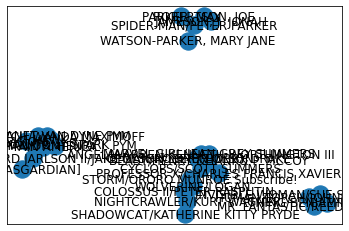

In [33]:
import matplotlib.pyplot as plt
nx.draw_networkx(graph, pos=nx.spring_layout(graph))
plt.show()